In [1]:
import numpy as np
import torch.optim as optim
import os,sys, re, time
import PIL
from PIL import Image as PILImage
import skimage
import torch
import torch.nn as nn
import torch.utils.data as data
import pandas as pd
import skimage
import torchvision
import sklearn
import matplotlib
import matplotlib.pyplot as plt
#matplotlib inline
import glob
from IPython.display import display, HTML
start = time.time()

In [11]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 59 kB 3.2 MB/s eta 0:00:011
     |████████████████████████████████| 499 kB 9.3 MB/s eta 0:00:01     |███████████▉                    | 184 kB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 7.1 MB 10.1 MB/s eta 0:00:01     |████████████████████▍           | 4.5 MB 10.1 MB/s eta 0:00:01     |████████████████████████▎       | 5.4 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.2 MB/s  eta 0:00:01
     |████████████████████████████████| 199 kB 12.4 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you pr

In [13]:
import yfinance as yf
import seaborn as sns; sns.set()

In [2]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print(f'Working on {device}')

Working on cuda


In [3]:
files = glob.glob('time_series_data' + '/*.csv')
df = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
df.head()

,Date,Open,High,Low,Close,Volume,Name,Unnamed: 0
0,2006-01-03,30.20,30.47,30.04,30.38,12903800,VZ,NaN
1,2006-01-04,30.57,31.29,30.45,31.27,31004500,VZ,NaN
2,2006-01-05,31.28,31.91,31.22,31.63,20664000,VZ,NaN
3,2006-01-06,31.60,31.60,31.16,31.35,57704300,VZ,NaN
4,2006-01-09,31.39,31.52,31.21,31.48,17600000,VZ,NaN


In [4]:
df['Name'].unique()

array(['VZ', 'AXP', 'MMM', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
       'DIS', 'XOM', 'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD',
       'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'WMT',
       'GOOGL', 'AMZN', 'AABA'], dtype=object)

In [5]:
df['Name'].unique().shape

(31,)

In [18]:
df[df['Unnamed: 0'] >= 0]['Name'].unique()

array(['AAPL'], dtype=object)

Text(0.5, 1.0, 'The Stock Price of Apple')

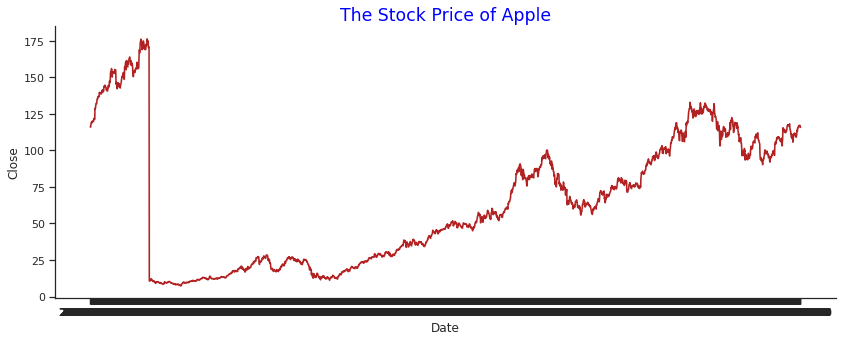

In [14]:
plt.figure(figsize=(14,5))
sns.set_style("ticks")
temp_df = df[df['Name'] == 'AAPL']
sns.lineplot(data=temp_df,x="Date",y='Close',color='firebrick')
sns.despine()
plt.title("The Stock Price of Apple",size='x-large',color='blue')

In [20]:
for f in files:
    comp = f.split('/')[1].split('_')[0]
    print(comp)

VZ
AXP
all
JPM
GE
KO
all
train
AAPL
UTX
WMT
CAT
AMZN
HD
PFE
XOM
MRK
CSCO
PG
test
GS
TRV
MSFT
BA
MMM
MCD
DIS
IBM
NKE
CVX
INTC
val
GOOGL
AABA
JNJ
UNH


In [15]:
#dataset class for loading a datapooint:
class StockData:
    def __init__(self,company, directory, data_set, seq_len):
        self.company = company
        self.data_set = data_set
        self.directory = directory
        self.seq_len = seq_len
        self.files = glob.glob(self.directory + '/*.csv')
        self.data = self.load_data(self.company)
        
        total = self.__len__()
        train_idx = 0
        test_idx = int(0.7*total)
        val_idx = int(0.85*total)
        
        if self.data_set == 'train':
            self.data = self.data[:test_idx]
        elif self.data_set == 'test':
            self.data = self.data[test_idx:val_idx]
        elif self.data_set == 'val':
            self.data = self.data[val_idx:]
        
        
    def __len__(self,):
        return len(self.data) - self.seq_len
        
    def load_data(self, company_name):
        data_ = []
        for file in self.files:
            comp_file = file.split('/')[1].split('_')[0]
            if comp_file == company_name:
                data_.append(pd.read_csv(file))
        df = pd.concat(data_, ignore_index = True)
        tensor_close = torch.tensor(df['Close'])
        return tensor_close
        
        
    def __getitem__(self,i):
        X = self.data[i:i+self.seq_len].float()
        y = self.data[i+self.seq_len].float()
        
        return (X,y)
        
        
        
        
        

In [16]:
#creating the data loaders:
train_batch_size = 512
company, directory, data_set, seq_len = 'AAPL', 'time_series_data', 'train', 20
train_data = StockData(company, directory, data_set, seq_len)
train_dataloader = data.DataLoader(train_data, batch_size = train_batch_size, shuffle=True)

test_batch_size = 64
company, directory, data_set, seq_len = 'AAPL', 'time_series_data', 'test', 20
test_data = StockData(company, directory, data_set, seq_len)
test_dataloader = data.DataLoader(test_data, batch_size = test_batch_size, shuffle=False)

val_batch_size = 512
company, directory, data_set, seq_len = 'AAPL', 'time_series_data', 'val', 20
val_data = StockData(company, directory, data_set, seq_len)
val_dataloader = data.DataLoader(val_data, batch_size = val_batch_size, shuffle=False)

In [20]:
#Model:

class MLP(nn.Module):
    def __init__(self,num_inputs):
        super(MLP,self).__init__()
        self.num_inputs = num_inputs
        self.l1 = nn.Linear(num_inputs, 1024)
        self.b = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout()
        self.l2 = nn.Linear(1024,1)
        self.drop2 = nn.Dropout()
        self.l3 = nn.Linear(512,1)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, X):
        X = self.l1(X)
        X = self.b(X)
        X = self.sigmoid(X)
        X = self.drop1(X)
        X = self.l2(X)
        #X = self.sigmoid(X)
        #X = self.drop2(X)
        #X = self.l3(X)
        return X

In [23]:

model = MLP(seq_len).to(device)
model.train()
lr = 0.00001
optimizer = optim.SGD(model.parameters(),lr = lr,weight_decay =1e-3)
loss_function = nn.MSELoss()
epochs = 1000

In [24]:
train_losses = []
val_losses = []


for e in range(1, epochs+1):
    curr_tr_loss = 0
    curr_val_loss = 0
    for X,y in train_dataloader:
        optimizer.zero_grad()
        X,y = X.to(device), y.to(device)
        output = model(X)
        loss = loss_function(output.view(-1), y)
        loss.backward()
        optimizer.step()
        curr_tr_loss += loss.div(train_batch_size)
    train_losses.append(curr_tr_loss.div(len(train_dataloader)).item())
    optimizer.zero_grad()
    
    #validation:
    for X,y in val_dataloader:
        X,y = X.to(device), y.to(device)
        output = model(X)
        loss = loss_function(output.view(-1), y)

        curr_val_loss += loss.div(val_batch_size)
    val_losses.append(curr_val_loss.div(len(val_dataloader)).item())
    
    print(f'Epoch : {e} || Train Loss : {curr_tr_loss.div(len(train_dataloader)).item()} || Val Loss : {curr_val_loss.div(len(val_dataloader)).item()}')
    
    
    

Epoch : 1 || Train Loss : 4.761617183685303 || Val Loss : 34.13591384887695
Epoch : 2 || Train Loss : 4.362814903259277 || Val Loss : 33.622196197509766
Epoch : 3 || Train Loss : 3.9608635902404785 || Val Loss : 33.09992218017578
Epoch : 4 || Train Loss : 3.923535108566284 || Val Loss : 32.61399459838867
Epoch : 5 || Train Loss : 3.7222976684570312 || Val Loss : 32.138797760009766
Epoch : 6 || Train Loss : 3.6725997924804688 || Val Loss : 31.672771453857422
Epoch : 7 || Train Loss : 3.4245216846466064 || Val Loss : 31.246807098388672
Epoch : 8 || Train Loss : 3.2853355407714844 || Val Loss : 30.816661834716797
Epoch : 9 || Train Loss : 3.3894524574279785 || Val Loss : 30.383222579956055
Epoch : 10 || Train Loss : 2.970057725906372 || Val Loss : 29.985387802124023
Epoch : 11 || Train Loss : 3.056398630142212 || Val Loss : 29.6014461517334
Epoch : 12 || Train Loss : 2.919832944869995 || Val Loss : 29.21601676940918
Epoch : 13 || Train Loss : 2.8992269039154053 || Val Loss : 28.8419761657

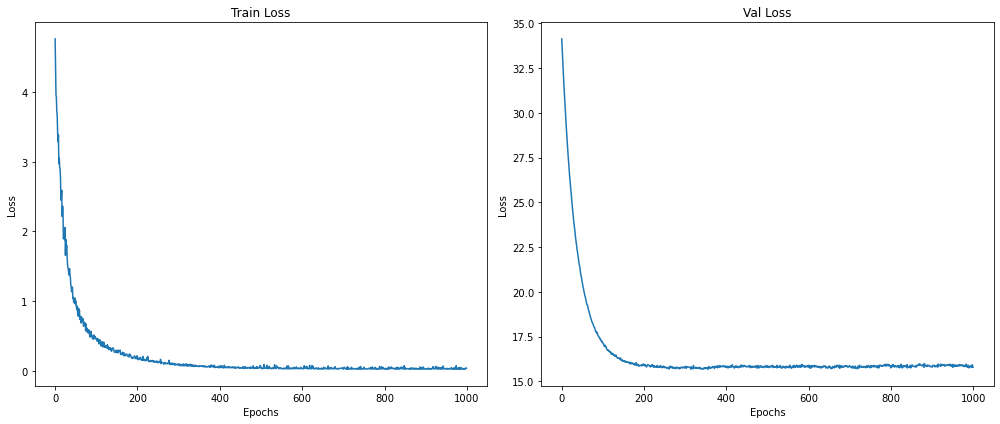

In [25]:
fig, (ax1, ax2)=plt.subplots(1,2)
ax1.plot(train_losses)
ax2.plot(val_losses)
ax1.set_title("Train Loss")
ax2.set_title("Val Loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
fig.set_size_inches(14, 6)
fig.tight_layout()
fig.savefig('DLSLab1.png', bbox_inches='tight')

In [26]:
class LSTM(nn.Module):
    def __init__(self, num_hidden, num_inputs, num_layers):
        super(LSTM, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(hidden_size=num_hidden,input_size = num_inputs, num_layers = num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size =num_hidden, hidden_size=num_hidden, num_layers = num_layers, batch_first=True)
        self.fc1 = nn.Linear(num_hidden,512)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(512,1)
        
    def forward(self,x):
        #print(f'Input size : {x.size()}')
        num_samples = x.size(0)
        h0 = torch.zeros(self.num_layers, num_samples, self.num_hidden).requires_grad_()
        c0 = torch.zeros(self.num_layers, num_samples, self.num_hidden).requires_grad_()
        h0,c0 = h0.to(device), c0.to(device)
        #print(f'Hidden State size : {h0.size()}')
        #print(f'Context vector size : {c0.size()}')
        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))
        #print(f' LSTM output size : {out.size()}')
        #print(f'FC input size {out[:,:,-1].size()}')
        out = self.fc1(out[:,-1,:])
        #print(f'FC1 output size : {out.size()}')
        out = self.fc2(out)
        #print(f'Final output size : {out.size()}')
        
        return out

In [27]:
num_hidden = 512
num_layers = 5
model = LSTM(num_hidden,1, num_layers).to(device)
model.train()
lr = 0.00001
optimizer = optim.SGD(model.parameters(),lr = lr,weight_decay =1e-3)
loss_function = nn.MSELoss()
epochs = 1000

In [28]:
print(model)

LSTM(
  (lstm1): LSTM(1, 512, num_layers=5, batch_first=True)
  (lstm2): LSTM(512, 512, num_layers=5, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [29]:
train_losses = []
val_losses = []


for e in range(1, epochs+1):
    curr_tr_loss = 0
    curr_val_loss = 0
    for X,y in train_dataloader:
        optimizer.zero_grad()
        X,y = X.to(device), y.to(device)
        X = X[:,:,None]
        
        output = model(X)
        #print(output.size(), y.size())
        loss = loss_function(output.view(-1), y)
        loss.backward()
        optimizer.step()
        curr_tr_loss += loss.div(train_batch_size)
    train_losses.append(curr_tr_loss.div(len(train_dataloader)).item())
    optimizer.zero_grad()
    
    #validation:
    for X,y in val_dataloader:
        X,y = X.to(device), y.to(device)
        X = X[:,:,None]
        output = model(X)
        loss = loss_function(output.view(-1), y)

        curr_val_loss += loss.div(val_batch_size)
    val_losses.append(curr_val_loss.div(len(val_dataloader)).item())
    
    print(f'Epoch : {e} || Train Loss : {curr_tr_loss.div(len(train_dataloader)).item()} || Val Loss : {curr_val_loss.div(len(val_dataloader)).item()}')
    
    
    

Epoch : 1 || Train Loss : 4.3708600997924805 || Val Loss : 34.71645736694336
Epoch : 2 || Train Loss : 4.33778190612793 || Val Loss : 34.71269989013672
Epoch : 3 || Train Loss : 4.751068592071533 || Val Loss : 34.70872116088867
Epoch : 4 || Train Loss : 4.777568340301514 || Val Loss : 34.70473861694336
Epoch : 5 || Train Loss : 4.264047145843506 || Val Loss : 34.70100784301758
Epoch : 6 || Train Loss : 4.457099437713623 || Val Loss : 34.69715118408203
Epoch : 7 || Train Loss : 4.604611873626709 || Val Loss : 34.6932487487793
Epoch : 8 || Train Loss : 4.340853214263916 || Val Loss : 34.68946838378906
Epoch : 9 || Train Loss : 4.680459499359131 || Val Loss : 34.68553924560547
Epoch : 10 || Train Loss : 4.568441867828369 || Val Loss : 34.6816291809082
Epoch : 11 || Train Loss : 4.371097564697266 || Val Loss : 34.67782974243164
Epoch : 12 || Train Loss : 4.532794952392578 || Val Loss : 34.67393493652344
Epoch : 13 || Train Loss : 4.428988456726074 || Val Loss : 34.67012405395508
Epoch : 14

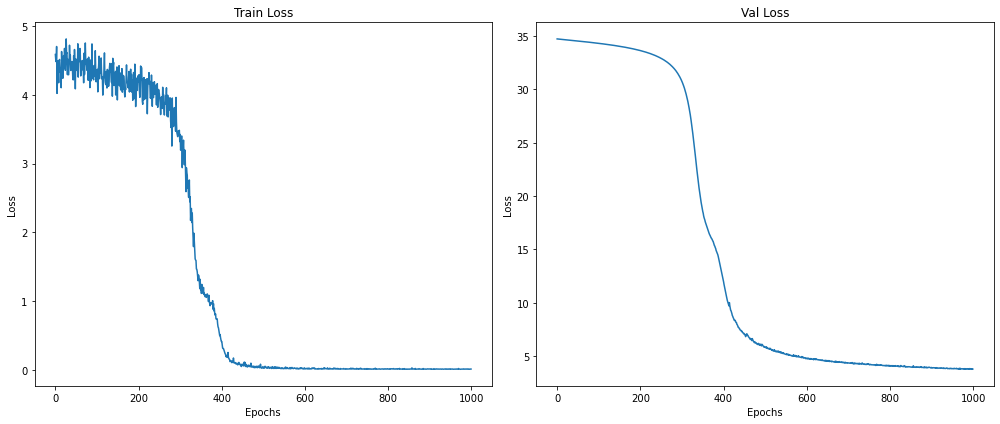

In [32]:
fig, (ax1, ax2)=plt.subplots(1,2)
ax1.plot(train_losses)
ax2.plot(val_losses)
ax1.set_title("Train Loss")
ax2.set_title("Val Loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
fig.set_size_inches(14, 6)
fig.tight_layout()
fig.savefig('DLSLab1.png', bbox_inches='tight')